In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data_clean/macro_dataset.csv")
df = df.sort_values(["country","date"])

df.head()


,country,date,inflation,unemployment
0,AT,1997-01-01,1.2,5.5
1,AT,1997-01-01,1.2,4.6
2,AT,1997-01-01,1.2,4.6
3,AT,1997-02-01,1.4,5.8
4,AT,1997-02-01,1.4,4.7


In [2]:
# yıllık enflasyon
df["inflation_yoy"] = df.groupby("country")["inflation"].pct_change(12) * 100

# gürültüyü azalt
df["inflation_smooth"] = (
    df.groupby("country")["inflation_yoy"]
    .rolling(12)
    .mean()
    .reset_index(level=0, drop=True)
)


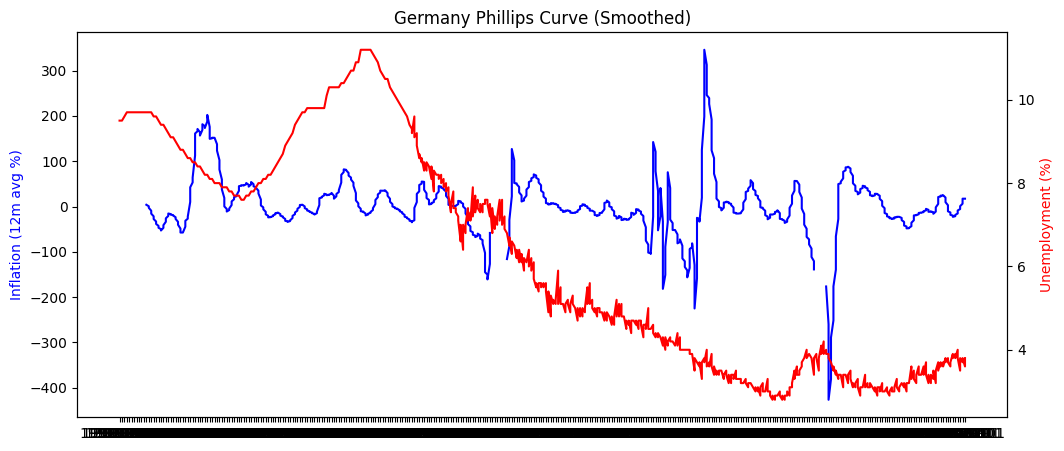

In [3]:
germany = df[df["country"]=="DE"]

plt.figure(figsize=(12,5))

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(germany["date"], germany["inflation_smooth"], color="blue")
ax2.plot(germany["date"], germany["unemployment"], color="red")

ax1.set_ylabel("Inflation (12m avg %)", color="blue")
ax2.set_ylabel("Unemployment (%)", color="red")

plt.title("Germany Phillips Curve (Smoothed)")
plt.show()


In [5]:
df["date"] = pd.to_datetime(df["date"])


In [6]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

panel = df.dropna(subset=["inflation_smooth","unemployment"]).copy()
panel = panel.set_index(["country","date"])

panel["unemp_lag"] = panel.groupby(level=0)["unemployment"].shift(6)
panel = panel.dropna()

X = sm.add_constant(panel["unemp_lag"])
y = panel["inflation_smooth"]

model = PanelOLS(y, X, entity_effects=True)
result = model.fit()

print(result.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:       inflation_smooth   R-squared:                        0.0017
Estimator:                   PanelOLS   R-squared (Between):             -0.0527
No. Observations:                7322   R-squared (Within):               0.0017
Date:                Mon, Feb 16 2026   R-squared (Overall):              0.0011
Time:                        23:42:51   Log-likelihood                  -4.3e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      12.649
Entities:                           8   P-value                           0.0004
Avg Obs:                       915.25   Distribution:                  F(1,7313)
Min Obs:                       722.00                                           
Max Obs:                       1001.0   F-statistic (robust):             12.649
                            

In [7]:
model = PanelOLS(y, X, entity_effects=True, time_effects=True)
result = model.fit(cov_type="robust")

print(result.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:       inflation_smooth   R-squared:                        0.0013
Estimator:                   PanelOLS   R-squared (Between):             -0.3540
No. Observations:                7322   R-squared (Within):              -0.0046
Date:                Mon, Feb 16 2026   R-squared (Overall):             -0.0081
Time:                        23:44:12   Log-likelihood                -4.183e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      9.1951
Entities:                           8   P-value                           0.0024
Avg Obs:                       915.25   Distribution:                  F(1,6975)
Min Obs:                       722.00                                           
Max Obs:                       1001.0   F-statistic (robust):             10.303
                            

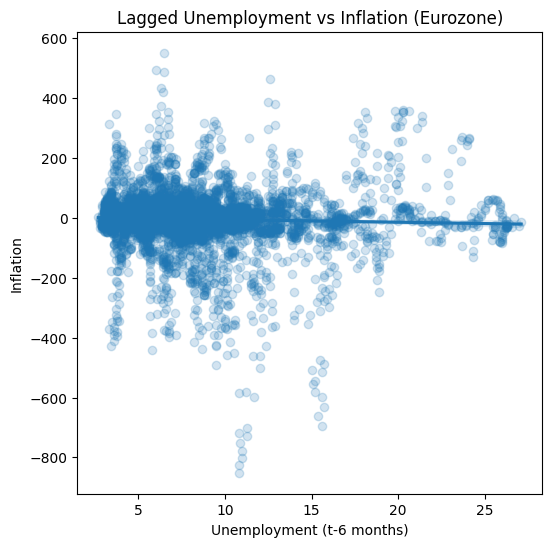

In [8]:
import seaborn as sns

plt.figure(figsize=(6,6))
sns.regplot(
    data=panel.reset_index(),
    x="unemp_lag",
    y="inflation_smooth",
    scatter_kws={"alpha":0.2}
)

plt.title("Lagged Unemployment vs Inflation (Eurozone)")
plt.xlabel("Unemployment (t-6 months)")
plt.ylabel("Inflation")
plt.show()
